## &#x1F310; &nbsp; Code Library, Style, and Links
The previous notebooks:

&#x1F4D8; &nbsp;  [PASSNYC. Data Exploration](https://www.kaggle.com/olgabelitskaya/passnyc-data-exploration)

&#x1F4D8; &nbsp;  [PASSNYC. Numeric and Categorical Variables](https://www.kaggle.com/olgabelitskaya/passnyc-numeric-and-categorical-variables)

&#x1F4D8; &nbsp;  [PASSNYC. Comparing All Districts with 5th District](passnyc-comparing-all-districts-with-5th-district)

Useful `LINKS`:

&#x1F4E1; &nbsp; [School Quality Reports. Educator Guide](http://schools.nyc.gov/NR/rdonlyres/967E0EE1-7E5D-4E47-BC21-573FEEE23AE2/0/201516EducatorGuideHS9252017.pdf)

&#x1F4E1; &nbsp; [New York City Department of Education](https://www.schools.nyc.gov)

&#x1F4E1; &nbsp; [NYC OpenData](https://opendata.cityofnewyork.us/)

&#x1F4E1; &nbsp; [Pandas Visualization](https://pandas.pydata.org/pandas-docs/stable/visualization.html)

&#x1F4E1; &nbsp; [Pandas Styling](https://pandas.pydata.org/pandas-docs/stable/style.html)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: #37c9e1; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #aaa;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}              
</style>

In [4]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline

from descartes import PolygonPatch

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge
from sklearn.linear_model import HuberRegressor, TheilSenRegressor, RANSACRegressor

In [6]:
# Function for fitting regressors
def regression(regressor, x_train, x_test, y_train):
    reg = regressor
    reg.fit(x_train, y_train)
    
    y_train_reg = reg.predict(x_train)
    y_test_reg = reg.predict(x_test)
    
    return y_train_reg, y_test_reg

# Function for metrics
def scores(regressor, y_train, y_test, y_train_reg, y_test_reg):
    print("_______________________________________")
    print(regressor)
    print("_______________________________________")
    print("EV score. Train: ", explained_variance_score(y_train, y_train_reg))
    print("EV score. Test: ", explained_variance_score(y_test, y_test_reg))
    print("---------")
    print("R2 score. Train: ", r2_score(y_train, y_train_reg))
    print("R2 score. Test: ", r2_score(y_test, y_test_reg))
    print("---------")
    print("MSE score. Train: ", mean_squared_error(y_train, y_train_reg))
    print("MSE score. Test: ", mean_squared_error(y_test, y_test_reg))
    print("---------")
    print("MAE score. Train: ", mean_absolute_error(y_train, y_train_reg))
    print("MAE score. Test: ", mean_absolute_error(y_test, y_test_reg))
    print("---------")
    print("MdAE score. Train: ", median_absolute_error(y_train, y_train_reg))
    print("MdAE score. Test: ", median_absolute_error(y_test, y_test_reg))

# Dataframe style
style_dict = {'background-color':'slategray',
              'color':'#37c9e1',
              'border-color': 'white',
              'font-family':'Roboto'}

## &#x1F310; &nbsp; Load and Preprocess the Data

In [73]:
school_explorer = pd.read_csv('2016 School Explorer.csv')
d5_shsat = pd.read_csv('D5 SHSAT Registrations and Testers.csv')
school_explorer.shape, d5_shsat.shape

((1272, 161), (140, 7))

In [74]:
drop_list = ['Adjusted Grade','New?','Other Location Code in LCGMS']
school_explorer = school_explorer.drop(drop_list, axis=1)
# Replace the same values
school_explorer.loc[[427,1023,712,908],'School Name'] = \
['P.S. 212 D12','P.S. 212 D30','P.S. 253 D21','P.S. 253 D27']
# Transform from string to numeric values 
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype('str') 
for s in [",","$"," "]:
    school_explorer['School Income Estimate'] = \
    school_explorer['School Income Estimate'].str.replace(s, "")
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].str.replace("nan", "0")
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype(float)
school_explorer['School Income Estimate'].replace(0, np.NaN, inplace=True)

percent_list = ['Percent ELL','Percent Asian','Percent Black',
                'Percent Hispanic','Percent Black / Hispanic',
                'Percent White','Student Attendance Rate',
                'Percent of Students Chronically Absent',
                'Rigorous Instruction %','Collaborative Teachers %',
                'Supportive Environment %','Effective School Leadership %',
                'Strong Family-Community Ties %','Trust %']

target_list = ['Average ELA Proficiency','Average Math Proficiency']
economic_list = ['Economic Need Index','School Income Estimate']
rating_list = ['Rigorous Instruction Rating','Collaborative Teachers Rating',
               'Supportive Environment Rating','Effective School Leadership Rating',
               'Strong Family-Community Ties Rating','Trust Rating',
               'Student Achievement Rating']
# Transform to numeric variables and fillna missing values
for el in percent_list:
    school_explorer[el] = school_explorer[el].astype('str')
    school_explorer[el] = school_explorer[el].str.replace("%", "")
    school_explorer[el] = school_explorer[el].str.replace("nan", "0")
    school_explorer[el] = school_explorer[el].astype(float)
    school_explorer[el].replace(0, np.NaN, inplace=True)
    school_explorer[el] = school_explorer[el].interpolate()

for el in target_list+economic_list:
    school_explorer[el] = school_explorer[el].interpolate()
    
for el in rating_list:
    moda_value = school_explorer[el].value_counts().idxmax()
    school_explorer[el] = school_explorer[el].fillna(moda_value)
    
# Preprocess categorical features      
category_list = ['District','Community School?','City','Grades']
                 
for feature in category_list:
    feature_cat = pd.factorize(school_explorer[feature])
    school_explorer[feature] = feature_cat[0]
    
for feature in rating_list:
    feature_pairs = dict(zip(['Not Meeting Target', 'Meeting Target', 
                              'Approaching Target', 'Exceeding Target'],
                             ['0','2','1','3']))
    school_explorer[feature].replace(feature_pairs,inplace=True)
    school_explorer[feature] = school_explorer[feature].astype(int)
    
category_list = list(category_list+rating_list)

numeric_list = list(school_explorer\
.columns[[4,5]+list(range(13,24))+[25,27,29,31,33]+list(range(38,158))])    
    
print('Number of Missing Values: ', sum(school_explorer.isna().sum()))

Number of Missing Values:  0


In [75]:
# Create a new dataframe
sat_list = ['DBN','Number of students who registered for the SHSAT',
            'Number of students who took the SHSAT']
d5_shsat_2016 = d5_shsat[sat_list][d5_shsat['Year of SHST']==2016]\
.groupby(['DBN'],as_index=False).agg(np.sum)
# Create a new variable
d5_shsat_2016['Took SHSAT %'] = \
d5_shsat_2016['Number of students who took the SHSAT']\
/ d5_shsat_2016['Number of students who registered for the SHSAT']

d5_shsat_2016['Took SHSAT %'] = \
d5_shsat_2016['Took SHSAT %'].fillna(0).apply(lambda x: round(x,3))
d5_shsat_2016.rename(columns={'DBN':'Location Code'}, inplace=True)
# Merge dataframes
d5_shsat_2016 = \
pd.merge(school_explorer[['Location Code']+numeric_list+category_list+target_list],
                         d5_shsat_2016, on='Location Code')

d5_shsat_2016.shape

(21, 155)

## &#x1F310; &nbsp; Split the Data for Regressor Training

#### The first set of features

In [76]:
# data = school_explorer, features = numeric veriables, targets = Average Math Proficiency
features1 = school_explorer[numeric_list].values
targets1 = school_explorer['Average Math Proficiency'].values

X_train1, X_test1, y_train1, y_test1 = \
train_test_split(features1, targets1, test_size=0.2, random_state=1)
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((1017, 138), (255, 138), (1017,), (255,))

In [77]:
# data = school_explorer, features = numeric veriables, targets = Average ELA Proficiency
targets2 = school_explorer['Average ELA Proficiency'].values

X_train2, X_test2, y_train2, y_test2 = \
train_test_split(features1, targets2, test_size=0.2, random_state=1)
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((1017, 138), (255, 138), (1017,), (255,))

#### The second set of features

In [78]:
# data = school_explorer, 
features_list = numeric_list+category_list 
# targets = Average Math Proficiency
features2 = school_explorer[features_list].values

X_train3, X_test3, y_train3, y_test3 = \
train_test_split(features2, targets1, test_size=0.2, random_state=1)
X_train3.shape, X_test3.shape, y_train3.shape, y_test3.shape

((1017, 149), (255, 149), (1017,), (255,))

In [79]:
# data = school_explorer, 
# targets = Average ELA Proficiency

X_train4, X_test4, y_train4, y_test4 = \
train_test_split(features2, targets2, test_size=0.2, random_state=1)
X_train4.shape, X_test4.shape, y_train4.shape, y_test4.shape

((1017, 149), (255, 149), (1017,), (255,))

## &#x1F310; &nbsp; Fit the Regressors

#### The first set of features
The predictions are based on the data about the financial situation, social environment, ethnic composition and test results of each grade.

In [80]:
y_train_gbr1, y_test_gbr1 = \
regression(GradientBoostingRegressor(max_depth=4, n_estimators=138), 
           X_train1, X_test1, y_train1)

scores('Gradient Boosting Regressor \nAverage Math Proficiency', 
       y_train1, y_test1, y_train_gbr1, y_test_gbr1)

_______________________________________
Gradient Boosting Regressor 
Average Math Proficiency
_______________________________________
EV score. Train:  0.9815852114203323
EV score. Test:  0.8945272866545283
---------
R2 score. Train:  0.9815852114203323
R2 score. Test:  0.8945190190922747
---------
MSE score. Train:  0.0040134599268851715
MSE score. Test:  0.02251896272807043
---------
MAE score. Train:  0.048859917349381846
MAE score. Test:  0.11425203338733089
---------
MdAE score. Train:  0.0398670038457154
MdAE score. Test:  0.08782391049705573


In [81]:
y_train_rfr1, y_test_rfr1 = \
regression(RandomForestRegressor(n_estimators=138), 
           X_train1, X_test1, y_train1)

scores('Random Forest Regressor \nAverage Math Proficiency', 
       y_train1, y_test1, y_train_rfr1, y_test_rfr1)

_______________________________________
Random Forest Regressor 
Average Math Proficiency
_______________________________________
EV score. Train:  0.9769331239883965
EV score. Test:  0.8795888872376975
---------
R2 score. Train:  0.9769182846846851
R2 score. Test:  0.8795601177408455
---------
MSE score. Train:  0.005030605649422001
MSE score. Test:  0.02571251420139621
---------
MAE score. Train:  0.05077357922562811
MAE score. Test:  0.12301144974898183
---------
MdAE score. Train:  0.03789855072463677
MdAE score. Test:  0.09558574879226933


In [82]:
y_train_gbr2, y_test_gbr2 = \
regression(GradientBoostingRegressor(max_depth=5, n_estimators=276), 
           X_train2, X_test2, y_train2)

scores('Gradient Boosting Regressor \nAverage ELA Proficiency', 
       y_train2, y_test2, y_train_gbr2, y_test_gbr2)

_______________________________________
Gradient Boosting Regressor 
Average ELA Proficiency
_______________________________________
EV score. Train:  0.9991525930620759
EV score. Test:  0.8692539677523933
---------
R2 score. Train:  0.9991525930620759
R2 score. Test:  0.86917276708694
---------
MSE score. Train:  0.00010655639219100777
MSE score. Test:  0.018789708961543472
---------
MAE score. Train:  0.007692157878821899
MAE score. Test:  0.1007977485070728
---------
MdAE score. Train:  0.0059483144717873415
MdAE score. Test:  0.07485197687007172


In [83]:
y_train_rfr2, y_test_rfr2 = \
regression(RandomForestRegressor(n_estimators=276), 
           X_train2, X_test2, y_train2)

scores('Random Forest Regressor \nAverage ELA Proficiency', 
       y_train1, y_test2, y_train_rfr2, y_test_rfr2)

_______________________________________
Random Forest Regressor 
Average ELA Proficiency
_______________________________________
EV score. Train:  0.8219390535070638
EV score. Test:  0.8499869236940374
---------
R2 score. Train:  0.7345229573560799
R2 score. Test:  0.8499815222484424
---------
MSE score. Train:  0.05786009801577555
MSE score. Test:  0.021545999812430192
---------
MAE score. Train:  0.18609301446662763
MAE score. Test:  0.10594414251207725
---------
MdAE score. Train:  0.14858695652174747
MdAE score. Test:  0.07732336956521779


#### The second set of features
The predictions are based on the data about the financial situation, social environment, ethnic composition, test results for each grade and geodata.

In [84]:
y_train_gbr3, y_test_gbr3 = \
regression(GradientBoostingRegressor(max_depth=4, n_estimators=81), 
           X_train3, X_test3, y_train3)

scores('Gradient Boosting Regressor \nAverage Math Proficiency', 
       y_train3, y_test3, y_train_gbr3, y_test_gbr3)

_______________________________________
Gradient Boosting Regressor 
Average Math Proficiency
_______________________________________
EV score. Train:  0.9717626146865521
EV score. Test:  0.9010320396996527
---------
R2 score. Train:  0.9717626146865521
R2 score. Test:  0.9009040915669183
---------
MSE score. Train:  0.006154271818285735
MSE score. Test:  0.021155824010216533
---------
MAE score. Train:  0.06038761631827774
MAE score. Test:  0.11154677102966196
---------
MdAE score. Train:  0.04975353013818351
MdAE score. Test:  0.09581834117297605


In [85]:
y_train_rfr3, y_test_rfr3 = \
regression(RandomForestRegressor(n_estimators=81), 
           X_train3, X_test3, y_train3)

scores('Random Forest Regressor \nAverage Math Proficiency', 
       y_train3, y_test3, y_train_rfr3, y_test_rfr3)

_______________________________________
Random Forest Regressor 
Average Math Proficiency
_______________________________________
EV score. Train:  0.9782381612380897
EV score. Test:  0.8869770766892757
---------
R2 score. Train:  0.9782376247999847
R2 score. Test:  0.886844608102874
---------
MSE score. Train:  0.004743058569542226
MSE score. Test:  0.02415736022440572
---------
MAE score. Train:  0.04768555442255322
MAE score. Test:  0.11688729524731711
---------
MdAE score. Train:  0.035185185185184764
MdAE score. Test:  0.08935185185185279


In [86]:
y_train_gbr4, y_test_gbr4 = \
regression(GradientBoostingRegressor(max_depth=4, n_estimators=108), 
           X_train4, X_test4, y_train4)

scores('Gradient Boosting Regressor \nAverage ELA Proficiency', 
       y_train4, y_test4, y_train_gbr4, y_test_gbr4)

_______________________________________
Gradient Boosting Regressor 
Average ELA Proficiency
_______________________________________
EV score. Train:  0.9768788926671613
EV score. Test:  0.8699199822405883
---------
R2 score. Train:  0.9768788926671613
R2 score. Test:  0.8698972844530102
---------
MSE score. Train:  0.002907341998973853
MSE score. Test:  0.018685652106231937
---------
MAE score. Train:  0.042012666810131466
MAE score. Test:  0.09755322368423468
---------
MdAE score. Train:  0.034864119319812925
MdAE score. Test:  0.07143640114213312


In [87]:
y_train_rfr4, y_test_rfr4 = \
regression(RandomForestRegressor(n_estimators=108), 
           X_train4, X_test4, y_train4)

scores('Random Forest Regressor \nAverage ELA Proficiency', 
       y_train4, y_test4, y_train_rfr4, y_test_rfr4)

_______________________________________
Random Forest Regressor 
Average ELA Proficiency
_______________________________________
EV score. Train:  0.9778183584083362
EV score. Test:  0.8555095142150423
---------
R2 score. Train:  0.9777986137922231
R2 score. Test:  0.8554793746669374
---------
MSE score. Train:  0.0027916925270111553
MSE score. Test:  0.02075638556655154
---------
MAE score. Train:  0.03750855442053002
MAE score. Test:  0.10170751028806581
---------
MdAE score. Train:  0.02805555555555861
MdAE score. Test:  0.0735185185185192


## &#x1F310; &nbsp; Display Predictions

#### The first set of features

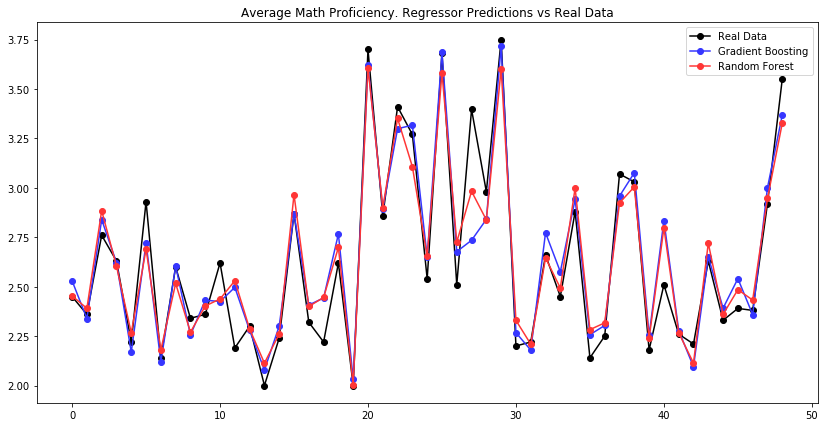

In [88]:
plt.figure(figsize = (14,7))

plt.plot(y_test1[1:50],'-o',color='black',label='Real Data')
plt.plot(y_test_gbr1[1:50],'-o',color='#3636ff',label='Gradient Boosting')
plt.plot(y_test_rfr1[1:50],'-o',color='#ff3636',label='Random Forest')

plt.legend()
plt.title("Average Math Proficiency. Regressor Predictions vs Real Data");

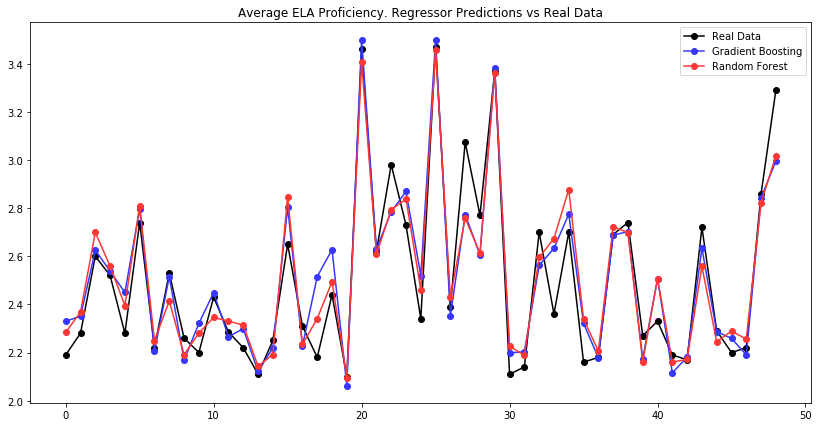

In [89]:
plt.figure(figsize = (14,7))

plt.plot(y_test2[1:50],'-o',color='black',label='Real Data')
plt.plot(y_test_gbr2[1:50],'-o',color='#3636ff',label='Gradient Boosting')
plt.plot(y_test_rfr2[1:50],'-o',color='#ff3636',label='Random Forest')

plt.legend()
plt.title("Average ELA Proficiency. Regressor Predictions vs Real Data");

#### The second set of features

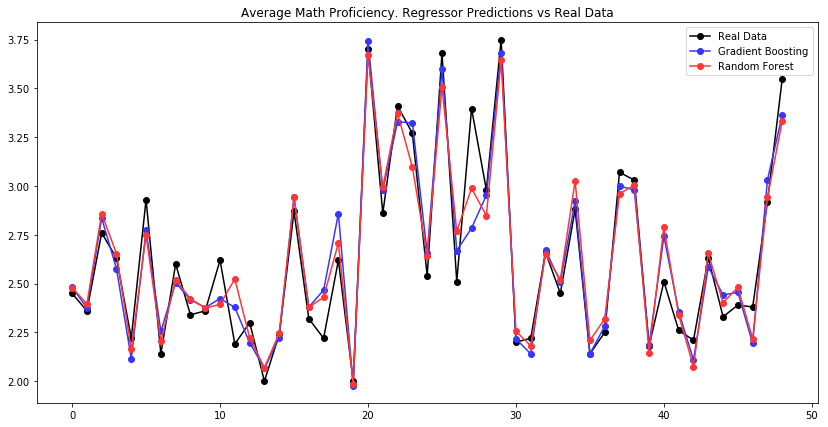

In [90]:
plt.figure(figsize = (14,7))

plt.plot(y_test3[1:50],'-o',color='black',label='Real Data')
plt.plot(y_test_gbr3[1:50],'-o',color='#3636ff',label='Gradient Boosting')
plt.plot(y_test_rfr3[1:50],'-o',color='#ff3636',label='Random Forest')

plt.legend()
plt.title("Average Math Proficiency. Regressor Predictions vs Real Data");

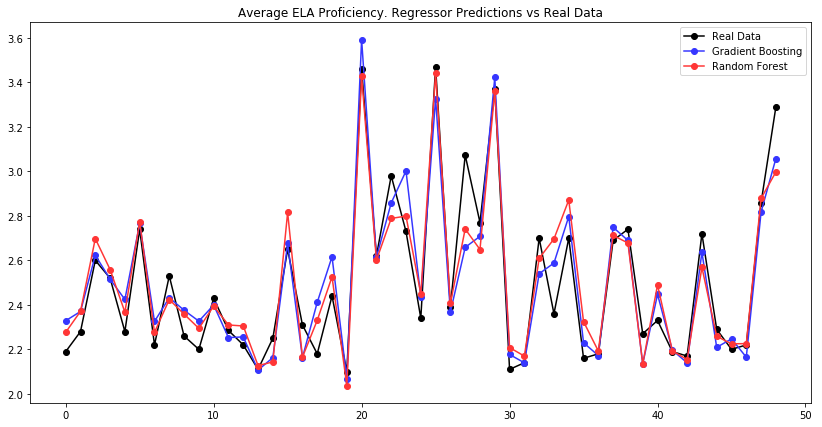

In [91]:
plt.figure(figsize = (14,7))

plt.plot(y_test4[1:50],'-o',color='black',label='Real Data')
plt.plot(y_test_gbr4[1:50],'-o',color='#3636ff',label='Gradient Boosting')
plt.plot(y_test_rfr4[1:50],'-o',color='#ff3636',label='Random Forest')

plt.legend()
plt.title("Average ELA Proficiency. Regressor Predictions vs Real Data");

Both sets of variables in the presented database about the financial situation, social environment, ethnic composition, geodata, and test results of each grade  make it possible to predict the indicators of learning outcomes `Average Math Proficiency`, `Average ELA Proficiency` quite well. 

- 0.85-0.90 is a really high level for `R2` - [(coefficient of determination)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)

## &#x1F310; &nbsp; Features' Importance

#### The first set of features

In [92]:
df_importance1 = pd.DataFrame(columns=range(138))

df_importance1.loc[0] = GradientBoostingRegressor(max_depth=4, n_estimators=138)\
.fit(X_train1, y_train1).feature_importances_
df_importance1.loc[1] = RandomForestRegressor(n_estimators=138)\
.fit(X_train1, y_train1).feature_importances_
df_importance1.loc[2] = GradientBoostingRegressor(max_depth=5, n_estimators=276)\
.fit(X_train2, y_train2).feature_importances_
df_importance1.loc[3]= RandomForestRegressor(n_estimators=276)\
.fit(X_train2, y_train2).feature_importances_

In [104]:
cmap = cm.get_cmap('Spectral',4)
spectral_cmap = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    spectral_cmap.append(mcolors.rgb2hex(rgb))

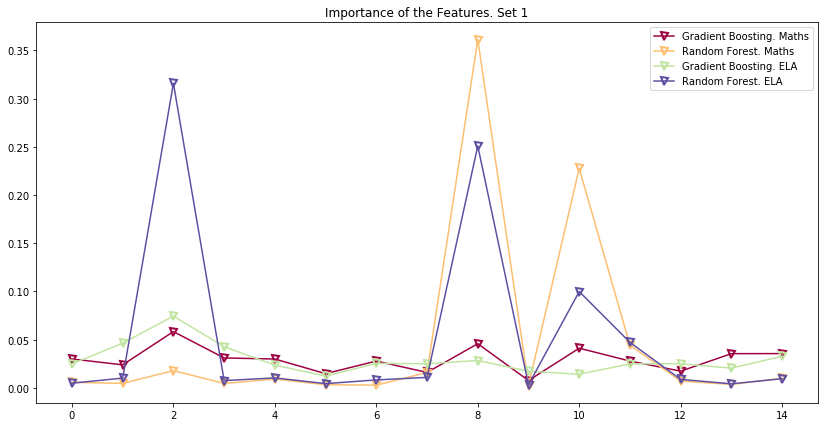

In [106]:
plt.figure(figsize=(14,7))
n=15

plt.plot(df_importance1.loc[0][:n],'-v',
         color=spectral_cmap[0],label='Gradient Boosting. Maths',
         markersize=7,markerfacecolor="None",markeredgewidth=2)
plt.plot(df_importance1.loc[1][:n],'-v',
         color=spectral_cmap[1],label='Random Forest. Maths',
         markersize=7,markerfacecolor="None",markeredgewidth=2)
plt.plot(df_importance1.loc[2][:n],'-v', 
         color=spectral_cmap[2],label='Gradient Boosting. ELA',
         markersize=7,markerfacecolor="None",markeredgewidth=2)
plt.plot(df_importance1.loc[3][:n],'-v', 
         color=spectral_cmap[3],label='Random Forest. ELA',
         markersize=7,markerfacecolor="None",markeredgewidth=2)

plt.legend()
plt.title("Importance of the Features. Set 1");

In [95]:
index_gbr_math1 = list(df_importance1.loc[0,].sort_values(ascending=False)[:20].index)
index_rfr_math1 = list(df_importance1.loc[1,].sort_values(ascending=False)[:20].index)
index_gbr_ela1 = list(df_importance1.loc[2,].sort_values(ascending=False)[:20].index)
index_rfr_ela1 = list(df_importance1.loc[3,].sort_values(ascending=False)[:20].index)

The most influential indicators for the variable `Average Math Proficiency`:

In [96]:
features1 = school_explorer[numeric_list]
for el in list(features1.iloc[:,index_gbr_math1].columns):
    if el in list(features1.iloc[:,index_rfr_math1].columns):
        print(el)

Economic Need Index
Percent Black / Hispanic
Student Attendance Rate
Supportive Environment %
Grade 5 Math 4s - All Students
Latitude
Percent ELL
Percent of Students Chronically Absent
Longitude
Grade 8 Math - All Students Tested
Strong Family-Community Ties %
Rigorous Instruction %
Grade 4 Math 4s - All Students


The most influential indicators for the variable `Average ELA Proficiency`:

In [97]:
for el in list(features1.iloc[:,index_gbr_ela1].columns):
    if el in list(features1.iloc[:,index_rfr_ela1].columns):
        print(el)

Economic Need Index
Longitude
School Income Estimate
Supportive Environment %
Percent Black / Hispanic
Percent Black
Rigorous Instruction %
Percent Hispanic
Percent of Students Chronically Absent
Strong Family-Community Ties %
Percent ELL
Grade 3 Math 4s - All Students
Grade 5 ELA 4s - All Students


#### The second set of features

In [98]:
df_importance2 = pd.DataFrame(columns=range(149))

df_importance2.loc[0] = GradientBoostingRegressor(max_depth=4, n_estimators=81)\
.fit(X_train3, y_train3).feature_importances_
df_importance2.loc[1] = RandomForestRegressor(n_estimators=81)\
.fit(X_train3, y_train3).feature_importances_
df_importance2.loc[2] = GradientBoostingRegressor(max_depth=4, n_estimators=108)\
.fit(X_train4, y_train4).feature_importances_
df_importance2.loc[3]= RandomForestRegressor(n_estimators=54)\
.fit(X_train4, y_train4).feature_importances_

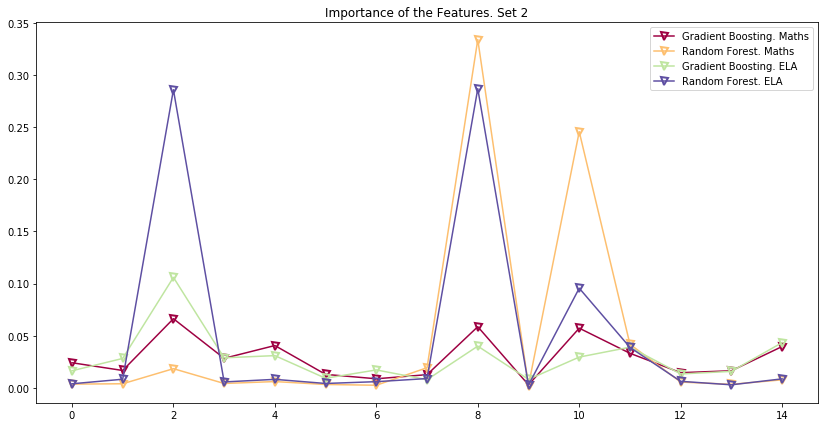

In [109]:
plt.figure(figsize=(14,7))
n=15

plt.plot(df_importance2.loc[0][:n],'-v',
         color=spectral_cmap[0],label='Gradient Boosting. Maths',
         markersize=7,markerfacecolor="None",markeredgewidth=2)
plt.plot(df_importance2.loc[1][:n],'-v',
         color=spectral_cmap[1],label='Random Forest. Maths',
         markersize=7,markerfacecolor="None",markeredgewidth=2)
plt.plot(df_importance2.loc[2][:n],'-v',
         color=spectral_cmap[2],label='Gradient Boosting. ELA',
         markersize=7,markerfacecolor="None",markeredgewidth=2)
plt.plot(df_importance2.loc[3][:n],'-v',
         color=spectral_cmap[3],label='Random Forest. ELA',
         markersize=7,markerfacecolor="None",markeredgewidth=2)

plt.legend()
plt.title("Importance of the Features. Set 2");

In [100]:
index_gbr_math2 = list(df_importance2.loc[0,].sort_values(ascending=False)[:15].index)
index_rfr_math2 = list(df_importance2.loc[1,].sort_values(ascending=False)[:15].index)
index_gbr_ela2 = list(df_importance2.loc[2,].sort_values(ascending=False)[:15].index)
index_rfr_ela2 = list(df_importance2.loc[3,].sort_values(ascending=False)[:15].index)

The most influential indicators for the variable `Average Math Proficiency`:

In [102]:
features2 = school_explorer[features_list]
for el in list(features2.iloc[:,index_gbr_math2].columns):
    if el in list(features2.iloc[:,index_rfr_math2].columns):
        print(el)

Economic Need Index
Percent Black / Hispanic
Student Attendance Rate
Student Achievement Rating
Grade 5 Math 4s - All Students
Percent ELL
Supportive Environment %
Percent of Students Chronically Absent
Grade 3 Math 4s - All Students
Strong Family-Community Ties %
Grade 4 Math 4s - All Students


The most influential indicators for the variable `Average ELA Proficiency`:

In [103]:
for el in list(features2.iloc[:,index_gbr_ela2].columns):
    if el in list(features2.iloc[:,index_rfr_ela2].columns):
        print(el)

Economic Need Index
Supportive Environment %
Percent Black / Hispanic
Percent of Students Chronically Absent
Student Achievement Rating
Strong Family-Community Ties %
Percent ELL
Student Attendance Rate
Longitude
Grade 5 ELA 4s - All Students
Grade 5 Math 4s - All Students


In general, we can make a list of the most influential indicators for the educational results.

- Financial: `Economic Need Index`
- Social: `Supportive Environment`
- Organizational: `Student Attendance Rate`, `Student Achievement Rating`, `Percent of Students Chronically Absent`
- Linguistical: `Percent ELL`
- Demographic: `Percent Black / Hispanic`